In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [3]:
import utils_io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import yaml
import json
import torch
from tqdm.notebook import tqdm
# --- Import our custom modules ---
# Use autoreload to pick up changes in .py files without restarting kernel
%load_ext autoreload
%autoreload 2


# --- Matplotlib Aesthetics Settings ---
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    'grid.alpha': 0.5,
    'grid.color': '#c0c0c0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.dpi': 300,
    'figure.edgecolor': 'black',
    'figure.facecolor': 'white',
    'figure.figsize': [6, 5],
})

# Load all seeds for 'diag' structure
data_diag = utils_io.load_results_from_dir('results/study_q2approx_v1/sequential')

# (You'll need logic to separate 'diag' from 'block' folders if they are in same parent,
# or save them in different parents like results/exp_diag/seed_x)

Loaded 0 seeds from results/study_q2approx_v1/sequential


## Approximation errors for different approximations 

In [90]:
def get_experiment_index(root_dir):
    """
    Scans config files and indexes experiments by their parameters.
    Extracts: mode, reg_type, seed, AND curvature.
    """
    configs = []
    files = glob.glob(os.path.join(root_dir, '**', 'config.yaml'), recursive=True)
    
    print(f"Indexing {len(files)} experiments...")
    for f in files:
        try:
            with open(f, 'r') as stream:
                try:
                    cfg = json.load(stream)
                except:
                    stream.seek(0)
                    cfg = yaml.safe_load(stream)
            
            # Robust extraction using keys from config
            configs.append({
                'config': cfg,
                'metrics_path': os.path.join(os.path.dirname(f), 'metrics.pt'),
                
                # Metadata for filtering
                'mode': cfg.get('training_mode', cfg.get('mode', 'unknown')),
                'reg_type': cfg.get('reg_type'),
                'seed': cfg.get('seed'),
                'alpha': cfg.get('alpha'),
                'curvature': cfg.get('curvature_type', 'hessian'), 
                'ignore_gradient': cfg.get('ignore_gradient', False) 
            })
        except Exception as e:
            continue
    return configs

def plot_trajectory_on_ax(ax, results, config, sample_ids='mean', metric_root='kappa_loss', use_abs=True):
    """
    Draws trajectory lines on a given axis.
    
    Args:
        metric_root: 'kappa_loss', 'kappa_grad', 'cos_sim'
        sample_ids: List of ints OR 'mean' to plot average with std band.
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    
    # Define metric keys based on root
    key_acc = f"{metric_root}_acc"
    key_res = f"{metric_root}_res"
    
    steps_axis = []
    
    # Containers for data aggregation
    # structure: [step_index] -> list of values (one per sample)
    data_acc = [] 
    data_res = []
    
    curr_step = 0
    
    # --- 1. Extract Data ---
    for t in range(1, num_tasks):
        if t not in results or 'history' not in results[t]:
            # Add placeholders or skip
            curr_step += num_steps
            continue
            
        history = results[t]['history']
        task_x = np.linspace(0, num_steps, len(history))
        
        for i, step_data in enumerate(history):
            steps_axis.append(curr_step + task_x[i])
            
            vals_a = []
            vals_r = []
            
            # Helper to safely extract and optionally apply abs
            def get_val(sample_dict, k):
                val = sample_dict.get(k, np.nan)
                if use_abs and not np.isnan(val):
                    return abs(val)
                return val

            # Extraction Logic
            if isinstance(sample_ids, list):
                for s_id in sample_ids:
                    if len(step_data) > s_id:
                        vals_a.append(get_val(step_data[s_id], key_acc))
                        vals_r.append(get_val(step_data[s_id], key_res))
            
            elif sample_ids == 'mean':
                for sample_stat in step_data:
                    vals_a.append(get_val(sample_stat, key_acc))
                    vals_r.append(get_val(sample_stat, key_res))
            
            data_acc.append(vals_a)
            data_res.append(vals_r)

        curr_step += num_steps

    if not steps_axis: return

    if isinstance(sample_ids, list):
        # --- Plot Individual Samples ---
        cmap_acc = plt.cm.Reds
        cmap_res = plt.cm.Blues
        colors_acc = cmap_acc(np.linspace(0.5, 1, len(sample_ids)))
        colors_res = cmap_res(np.linspace(0.5, 1, len(sample_ids)))
        
        # We need to transpose data: [steps][samples] -> [samples][steps]
        # Using numpy for easy slicing, padding with nan if lengths differ
        # (Simplified loop since we built flat lists above, but we need structure)
        
        # Re-looping for plotting simply:
        # Since aggregating data_acc is jagged (diff samples per step possible), 
        # we'll plot point-by-point or rebuild the structure. 
        # Actually, simpler to just iterate extraction logic again or restructure data_acc.
        # Let's use the simplest approach: Re-extract per sample ID.
        
        # (Redoing loop for clarity/robustness with Matplotlib lines)
        # Re-extract just for clean plotting loop (simplified)
        curr_step = 0
        for idx, s_id in enumerate(sample_ids):
            s_steps = []
            s_vals_a = []
            s_vals_r = []
            curr_step = 0
            for t in range(1, num_tasks):
                history = results.get(t, {}).get('history', [])
                task_x = np.linspace(0, num_steps, len(history))
                for i, step_data in enumerate(history):
                    if len(step_data) > s_id:
                        s_steps.append(curr_step + task_x[i])
                        # Apply abs if requested
                        va = step_data[s_id].get(key_acc, np.nan)
                        vr = step_data[s_id].get(key_res, np.nan)
                        if use_abs:
                            va = abs(va) if not np.isnan(va) else va
                            vr = abs(vr) if not np.isnan(vr) else vr
                        s_vals_a.append(va)
                        s_vals_r.append(vr)
                curr_step += num_steps
            
            ax.plot(s_steps, s_vals_a, color=colors_acc[idx], ls='-', lw=1.5, alpha=0.8)
            ax.plot(s_steps, s_vals_r, color=colors_res[idx], ls='--', lw=1.5, alpha=0.8)

    elif sample_ids == 'mean':
        # --- Plot Average with Shaded Std Dev ---
        # Note: Values are already abs() inside data_acc/data_res if use_abs=True
        
        means_acc = np.array([np.nanmean(v) for v in data_acc])
        stds_acc  = np.array([np.nanstd(v) for v in data_acc])
        
        means_res = np.array([np.nanmean(v) for v in data_res])
        stds_res  = np.array([np.nanstd(v) for v in data_res])
        
        ax.plot(steps_axis, means_acc, color='darkred', ls='-', lw=2, label='Accum Mean')
        ax.plot(steps_axis, means_res, color='darkblue', ls='--', lw=2, label='Reset Mean')
        
        ax.fill_between(steps_axis, means_acc - stds_acc, means_acc + stds_acc, color='red', alpha=0.15)
        ax.fill_between(steps_axis, means_res - stds_res, means_res + stds_res, color='blue', alpha=0.15)
        
        # Heuristic Y-Limit for Error Plots
        if use_abs: 
            pass
            # ax.set_ylim(0, max(np.nanmax(means_res), np.nanmax(means_acc)) * 1.5)

    # Boundaries & Grid
    for t in range(1, num_tasks):
        ax.axvline(x=t * num_steps, color='gray', linestyle=':', alpha=0.3)

    # Dynamic Limits based on metric type
    if 'cos_sim' in metric_root:
        ax.set_ylim(-1.1, 1.1) # Cosine sim is bounded
    else:
        # Heuristic limits for Kappa errors which can explode
        # ax.set_ylim(min(-1, plot_y_min), min(plot_y_max * 1.2, 50.0))
        pass

    ax.grid(True, linestyle=':', alpha=0.5)

def plot_grid(root_dir, metric='kappa_loss', sample_ids='mean', seed_to_plot=42, 
              curvature='hessian', ignore_gradient=False, use_abs=None):
    """
    Plots a grid of results (Modes x RegTypes).
    
    Args:
        curvature (str): 'hessian' or 'fisher'
        ignore_gradient (bool): True to see experiments where g*delta was dropped.
    """
    
    # Auto-detect absolute value
    if use_abs is None:
        use_abs = True if 'kappa' in metric else False

    index = get_experiment_index(root_dir)
    
    modes = ['sequential', 'regularized', 'replay']
    reg_types = ['taylor-diag', 'taylor-block', 'taylor-full']
    
    rows, cols = len(modes), len(reg_types)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), dpi=150, sharex=True, sharey=False)
    
    if rows == 1 and cols == 1: axes = np.array([[axes]])
    elif rows == 1: axes = axes[np.newaxis, :]
    elif cols == 1: axes = axes[:, np.newaxis]

    grad_status = "NoGrad" if ignore_gradient else "WithGrad"
    print(f"Plotting {metric} | {curvature} | {grad_status} | Seed {seed_to_plot}")

    for r, mode in enumerate(modes):
        for c, reg in enumerate(reg_types):
            ax = axes[r, c]
            
            # --- FILTERING LOGIC ---
            match = None
            for item in index:
                if (item['mode'] == mode and 
                    item['reg_type'] == reg and 
                    item['seed'] == seed_to_plot and 
                    item['curvature'] == curvature and 
                    item.get('ignore_gradient', False) == ignore_gradient): # <--- NEW FILTER
                    
                    match = item
                    break
            
            if match:
                try:
                    results = torch.load(match['metrics_path'], map_location='cpu', weights_only=False)
                    config = match['config']
                    plot_trajectory_on_ax(ax, results, config, sample_ids=sample_ids, metric_root=metric, use_abs=use_abs)
                    
                    if r == 0: ax.set_title(f"{reg}", fontsize=14, fontweight='bold')
                    if c == 0: ax.set_ylabel(f"{mode}\n{metric}", fontsize=12, fontweight='bold')
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error: {e}", ha='center', transform=ax.transAxes, fontsize=8)
            else:
                ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes, color='gray')
                if r == 0: ax.set_title(f"{reg}")
                if c == 0: ax.set_ylabel(f"{mode}")

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='darkred', lw=2, linestyle='-'),
        Line2D([0], [0], color='darkblue', lw=2, linestyle='--')
    ]
    fig.legend(custom_lines, ['Accumulate (Robust)', 'Reset (Unstable)'], 
               loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.show()

Indexing 55 experiments...
Plotting kappa_loss (Curvature: hessian) for Seed 33...


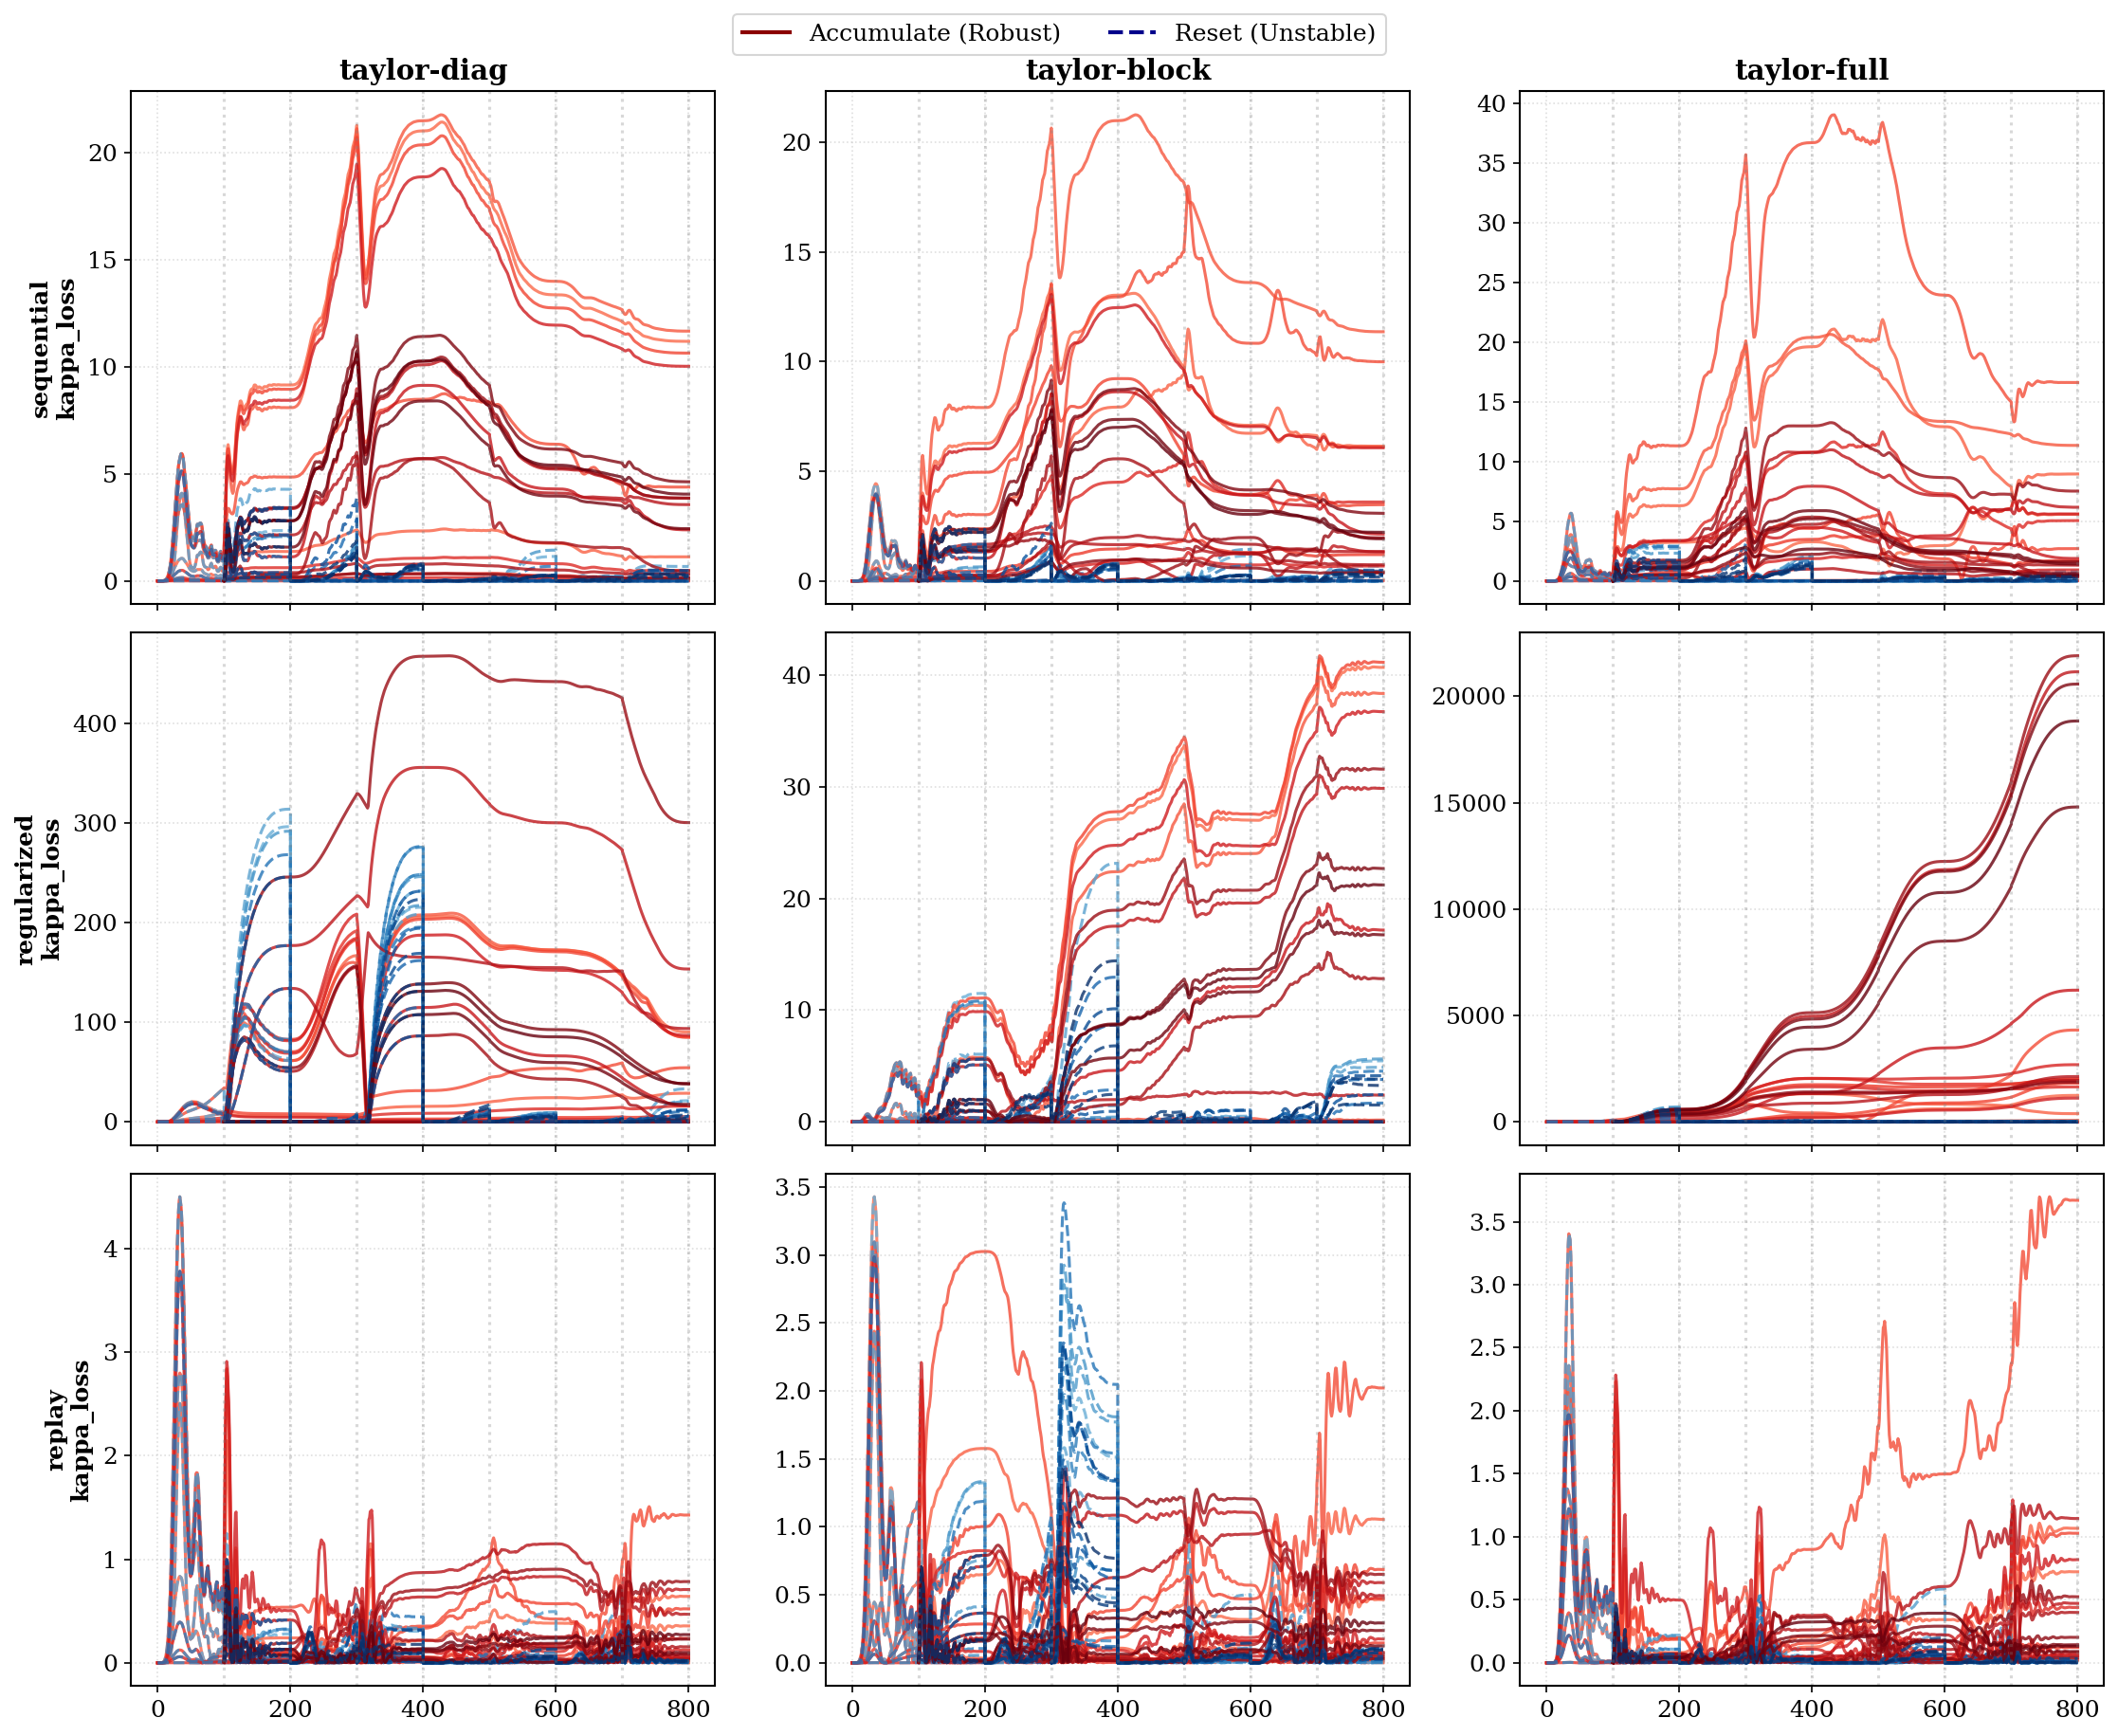

In [81]:
ROOT_DIR = './results/study_q2approx_v1'
# 1. Average Kappa Error (All Samples)
samples = list(range(20))
plot_grid(ROOT_DIR, metric='kappa_loss', sample_ids=samples, seed_to_plot=33, 
              curvature='hessian', use_abs=True)

# # 2. Individual Samples - Gradient Norm Error
# plot_grid(ROOT_DIR, metric='kappa_grad', sample_ids=[0, 10, 20])

# # 3. Average Cosine Similarity
# plot_grid(ROOT_DIR, metric='cos_sim', sample_ids='mean')

In [91]:
def extract_trajectory_series(results, config, metric_root, sample_ids='mean', use_abs=False):
    """
    Extracts a single 1D array (time series) for Accumulate and Reset strategies
    from a single experiment result.
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    
    key_acc = f"{metric_root}_acc"
    key_res = f"{metric_root}_res"
    
    steps_axis = []
    vals_acc = []
    vals_res = []
    
    curr_step = 0
    
    # --- Extraction Loop ---
    for t in range(1, num_tasks):
        if t not in results or 'history' not in results[t]:
            curr_step += num_steps
            continue
            
        history = results[t]['history']
        task_x = np.linspace(0, num_steps, len(history))
        
        for i, step_data in enumerate(history):
            steps_axis.append(curr_step + task_x[i])
            
            # Temporary lists for this specific step
            step_v_a = []
            step_v_r = []
            
            # Helper to get value
            def get_val(d, k):
                v = d.get(k, np.nan)
                if use_abs and not np.isnan(v): return abs(v)
                return v

            # 1. Filter Samples
            if sample_ids == 'mean':
                # Use all samples present in this step
                for s_stat in step_data:
                    step_v_a.append(get_val(s_stat, key_acc))
                    step_v_r.append(get_val(s_stat, key_res))
            else:
                # Use specific samples
                for s_id in sample_ids:
                    if len(step_data) > s_id:
                        step_v_a.append(get_val(step_data[s_id], key_acc))
                        step_v_r.append(get_val(step_data[s_id], key_res))
            
            # 2. Average across samples for this step (Mean of Samples)
            # This reduces [Samples] -> Scalar
            vals_acc.append(np.nanmean(step_v_a))
            vals_res.append(np.nanmean(step_v_r))

        curr_step += num_steps
        
    return np.array(steps_axis), np.array(vals_acc), np.array(vals_res)

In [99]:
def plot_metric_comparison(root_dir, metric='kappa_loss', 
                           compare_by='reg_type', 
                           fixed_params={'mode': 'regularized'},
                           curvature='hessian',
                           ignore_gradient=False, # Default filter
                           strategy='accumulate', 
                           sample_ids='mean'):
    """
    Plots a comparison of aggregated trajectories.
    
    Args:
        compare_by: Variable to use for colors ('ignore_gradient', 'reg_type', etc.)
        ignore_gradient: Filter value (True/False). Ignored if compare_by='ignore_gradient'.
    """
    
    index = get_experiment_index(root_dir)
    
    # Filter Experiments
    relevant_exps = []
    for item in index:
        
        # 1. Check Curvature
        if item.get('curvature') != curvature: continue
        
        # 2. Check Ignore Gradient (ONLY if we are not comparing by it)
        # If we compare by it, we want BOTH True and False to pass through
        if compare_by != 'ignore_gradient':
            if item.get('ignore_gradient', False) != ignore_gradient: continue

        # 3. Check User Fixed Params
        match = True
        for k, v in fixed_params.items():
            if item.get(k) != v:
                match = False
                break
        if match:
            relevant_exps.append(item)
            
    # Grouping
    groups = {}
    for item in relevant_exps:
        # Handle boolean keys nicely for labels
        key = item.get(compare_by, 'unknown')
        if isinstance(key, bool) and compare_by == 'ignore_gradient':
            key = "No Gradient" if key else "With Gradient"
            
        if key not in groups: groups[key] = []
        groups[key].append(item)
        
    if not groups:
        print("No matching experiments found!")
        return

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    unique_keys = sorted(groups.keys())
    colors = plt.cm.tab10(np.linspace(0.1, 0.9, len(unique_keys)))
    
    print(f"Comparing {compare_by} (Curv: {curvature}, IgnGrad: {ignore_gradient if compare_by != 'ignore_gradient' else 'VAR'})...")

    for idx, group_key in enumerate(unique_keys):
        seed_items = groups[group_key]
        color = colors[idx]
        
        acc_list = []
        res_list = []
        steps_ref = None
        
        for m in seed_items:
            try:
                res = torch.load(m['metrics_path'], map_location='cpu', weights_only=False)
                cfg = m['config']
                use_abs = True if 'kappa' in metric else False
                
                steps, v_acc, v_res = extract_trajectory_series(
                    res, cfg, metric, sample_ids, use_abs
                )
                
                if steps_ref is None: steps_ref = steps
                elif len(steps) != len(steps_ref):
                    mn = min(len(steps), len(steps_ref))
                    steps = steps[:mn]; v_acc = v_acc[:mn]; v_res = v_res[:mn]
                    steps_ref = steps_ref[:mn]
                    acc_list = [x[:mn] for x in acc_list]
                    res_list = [x[:mn] for x in res_list]

                acc_list.append(v_acc)
                res_list.append(v_res)
            except: continue
            
        if not acc_list: continue
        
        mean_acc = np.nanmean(np.vstack(acc_list), axis=0)
        std_acc = np.nanstd(np.vstack(acc_list), axis=0)
        mean_res = np.nanmean(np.vstack(res_list), axis=0)
        std_res = np.nanstd(np.vstack(res_list), axis=0)
        
        if strategy in ['accumulate', 'both']:
            ax.plot(steps_ref, mean_acc, color=color, ls='-', lw=2, label=f"{group_key} (Accum)")
            ax.fill_between(steps_ref, mean_acc-std_acc, mean_acc+std_acc, color=color, alpha=0.1)
            
        if strategy in ['reset', 'both']:
            ls = '--' if strategy == 'both' else '-'
            label = f"{group_key} (Reset)" if strategy == 'both' else f"{group_key}"
            ax.plot(steps_ref, mean_res, color=color, ls=ls, lw=2, label=label)
            if strategy == 'reset':
                ax.fill_between(steps_ref, mean_res-std_res, mean_res+std_res, color=color, alpha=0.1)
                
    fixed_params_str = ', '.join([f"{k}={v}" for k, v in fixed_params.items()])
    ax.set_title(f"Comparison of {metric}\n( {fixed_params_str} )", fontsize=14)
    ax.set_ylabel(metric + (" (MAE)" if 'kappa' in metric else ""))
    ax.set_xlabel("Global Steps")
    
    # Boundaries
    num_tasks = seed_items[0]['config']['environment_args']['num_tasks']
    num_steps = seed_items[0]['config']['num_steps']
    for t in range(1, num_tasks):
        ax.axvline(x=t*num_steps, color='gray', linestyle=':', alpha=0.3)
        
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Indexing 82 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: True)...


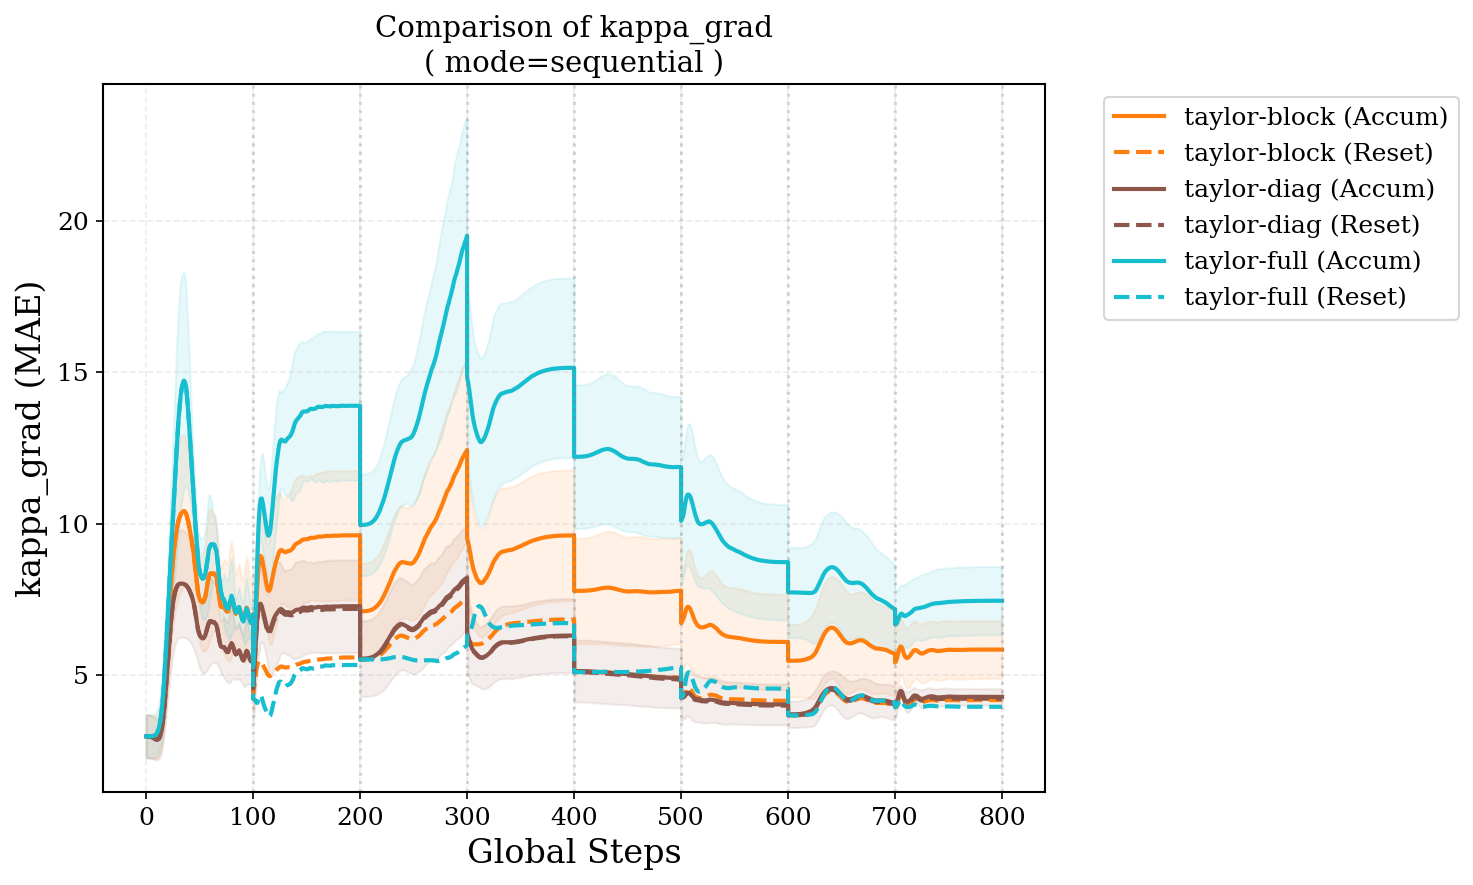

Indexing 82 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: True)...


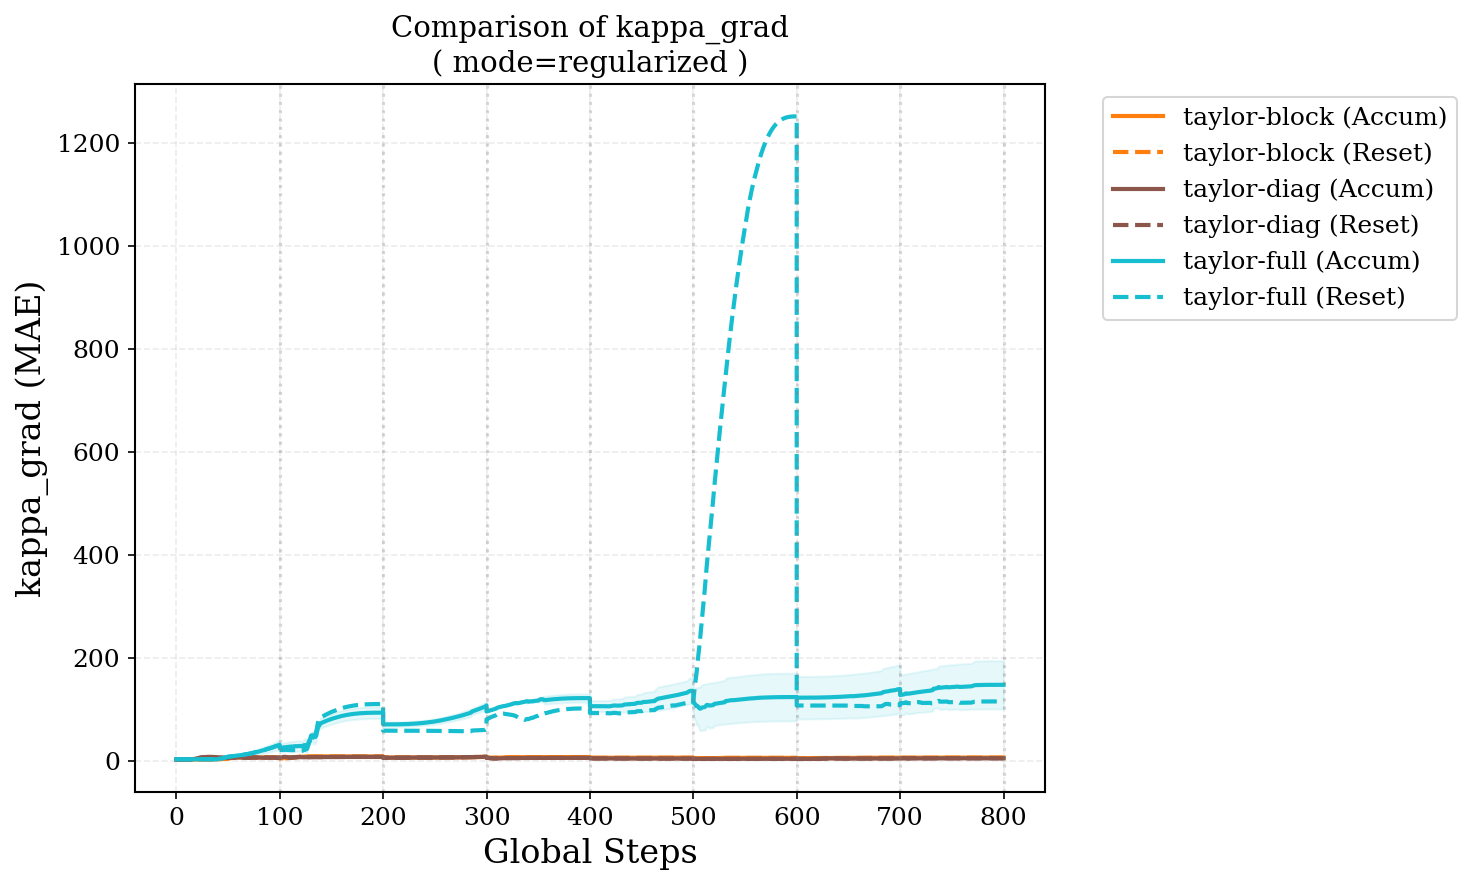

Indexing 82 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: True)...


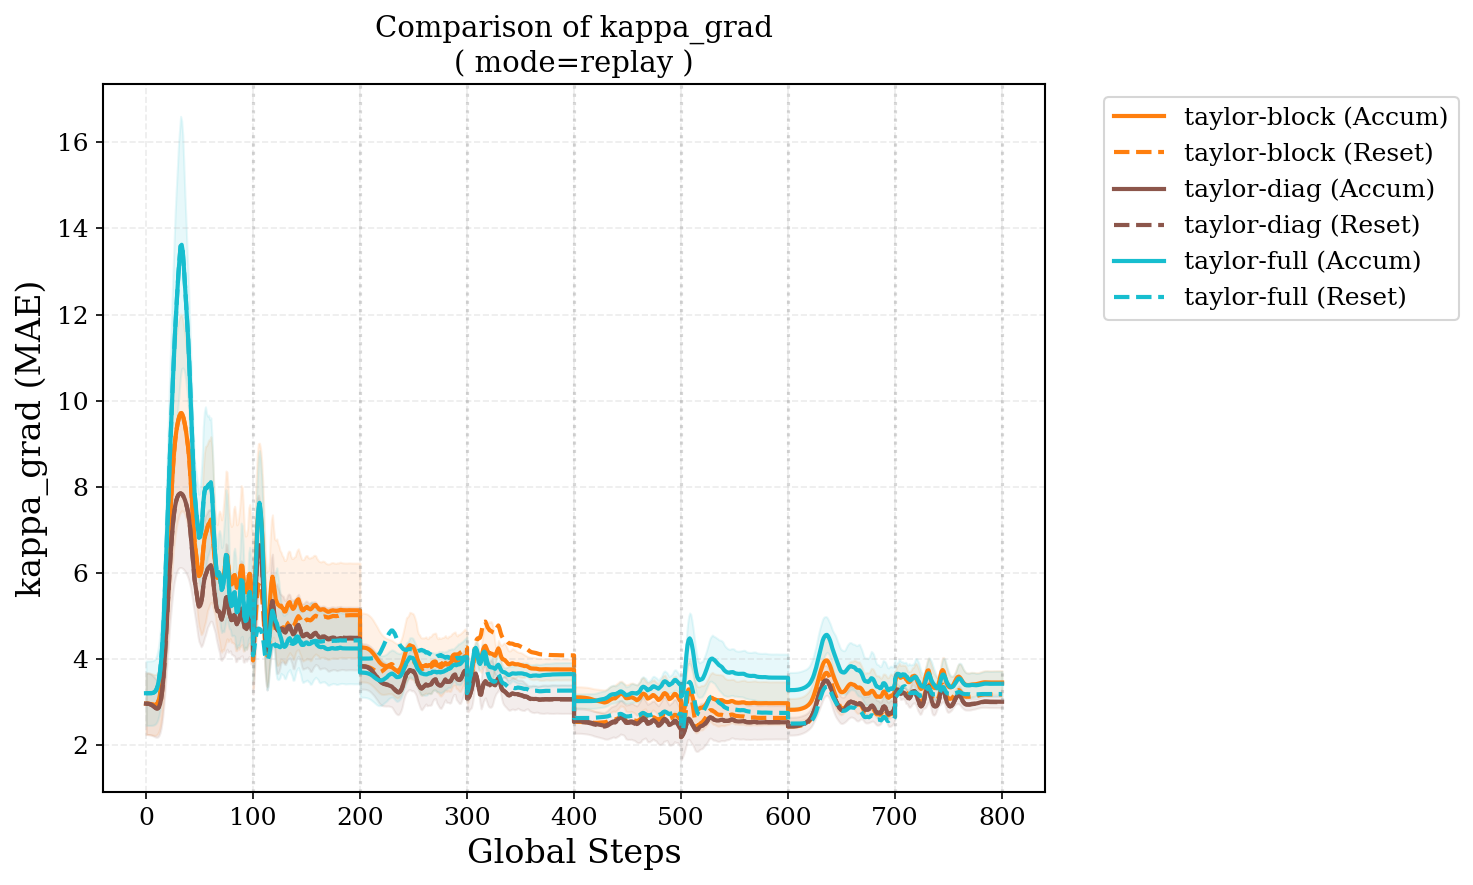

In [105]:
ROOT_DIR = './results/study_q2approx_v1'

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_grad',
    compare_by='reg_type', # <--- Auto-disables the ignore_gradient filter
    fixed_params={'mode': 'sequential'},
    curvature='fisher',
    strategy='both' , 
    ignore_gradient=True
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_grad',
    compare_by='reg_type', # <--- Auto-disables the ignore_gradient filter
    fixed_params={'mode': 'regularized'},
    curvature='fisher',
    strategy='both', 
    ignore_gradient=True
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_grad',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'replay'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='fisher', 
    ignore_gradient=True
)

Indexing 59 experiments...
Comparing reg_type (Fixed: {'mode': 'regularized'}, Curv: hessian)...


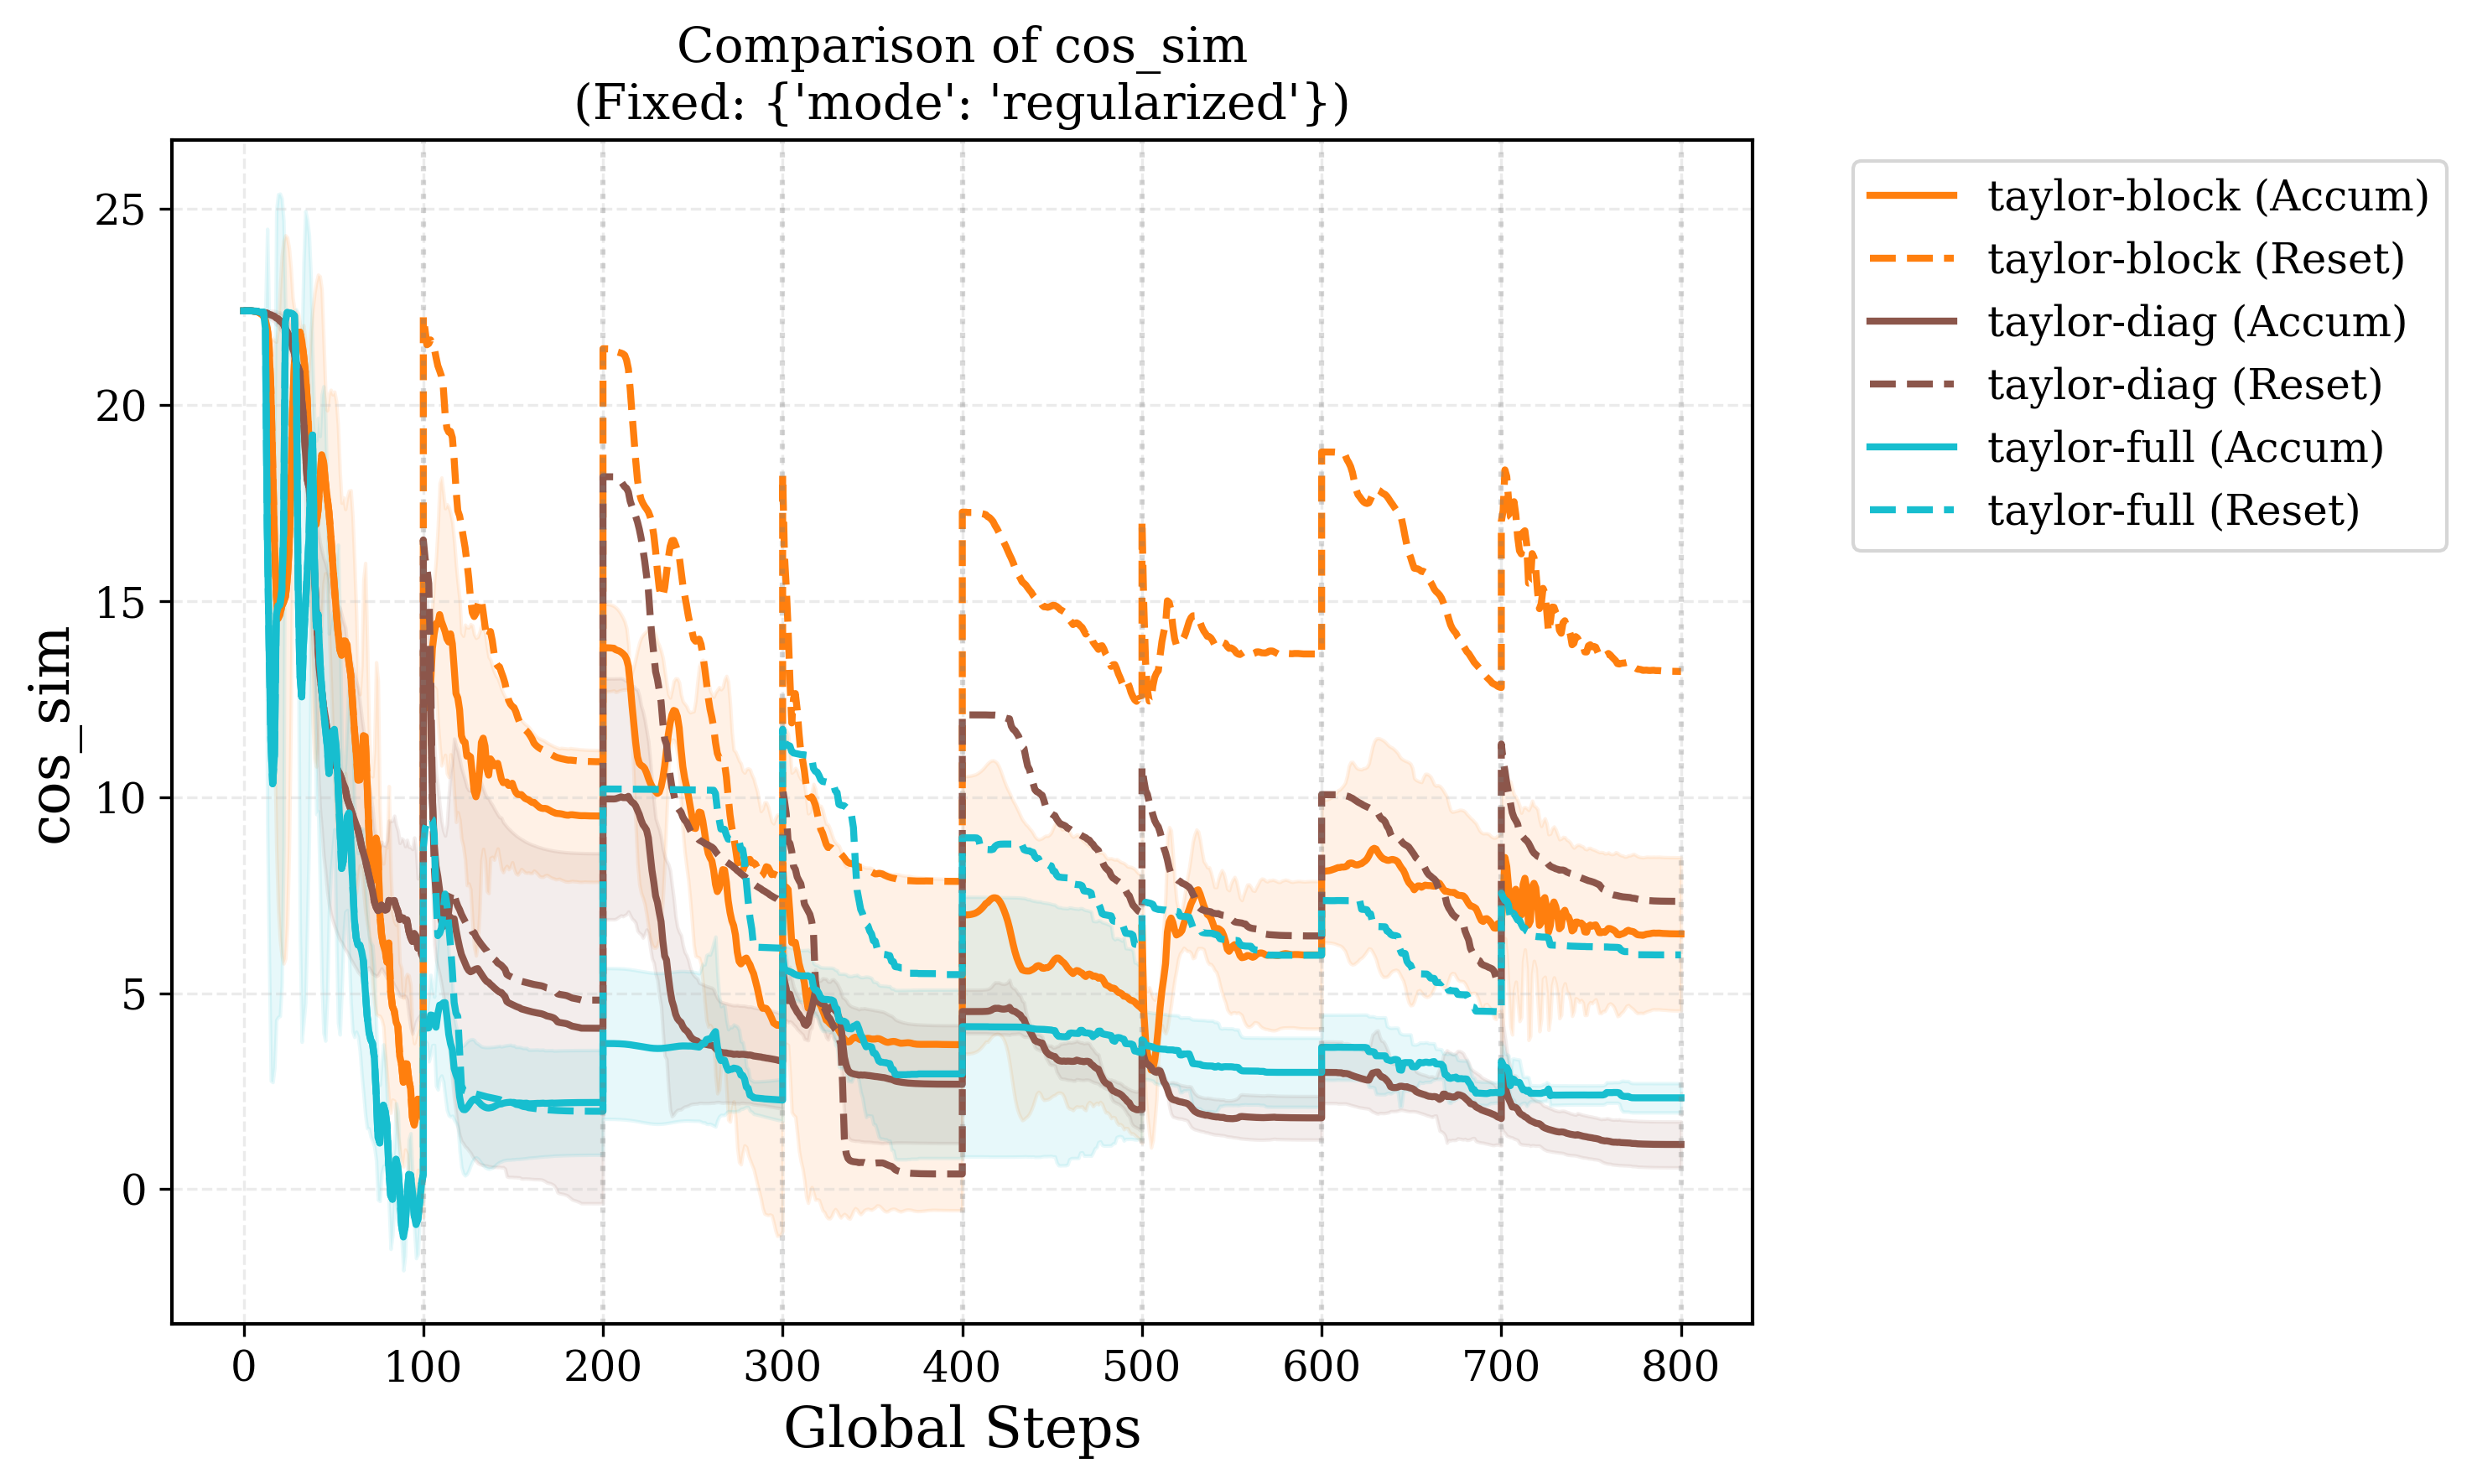

Indexing 59 experiments...
Comparing reg_type (Fixed: {'mode': 'regularized'}, Curv: fisher)...


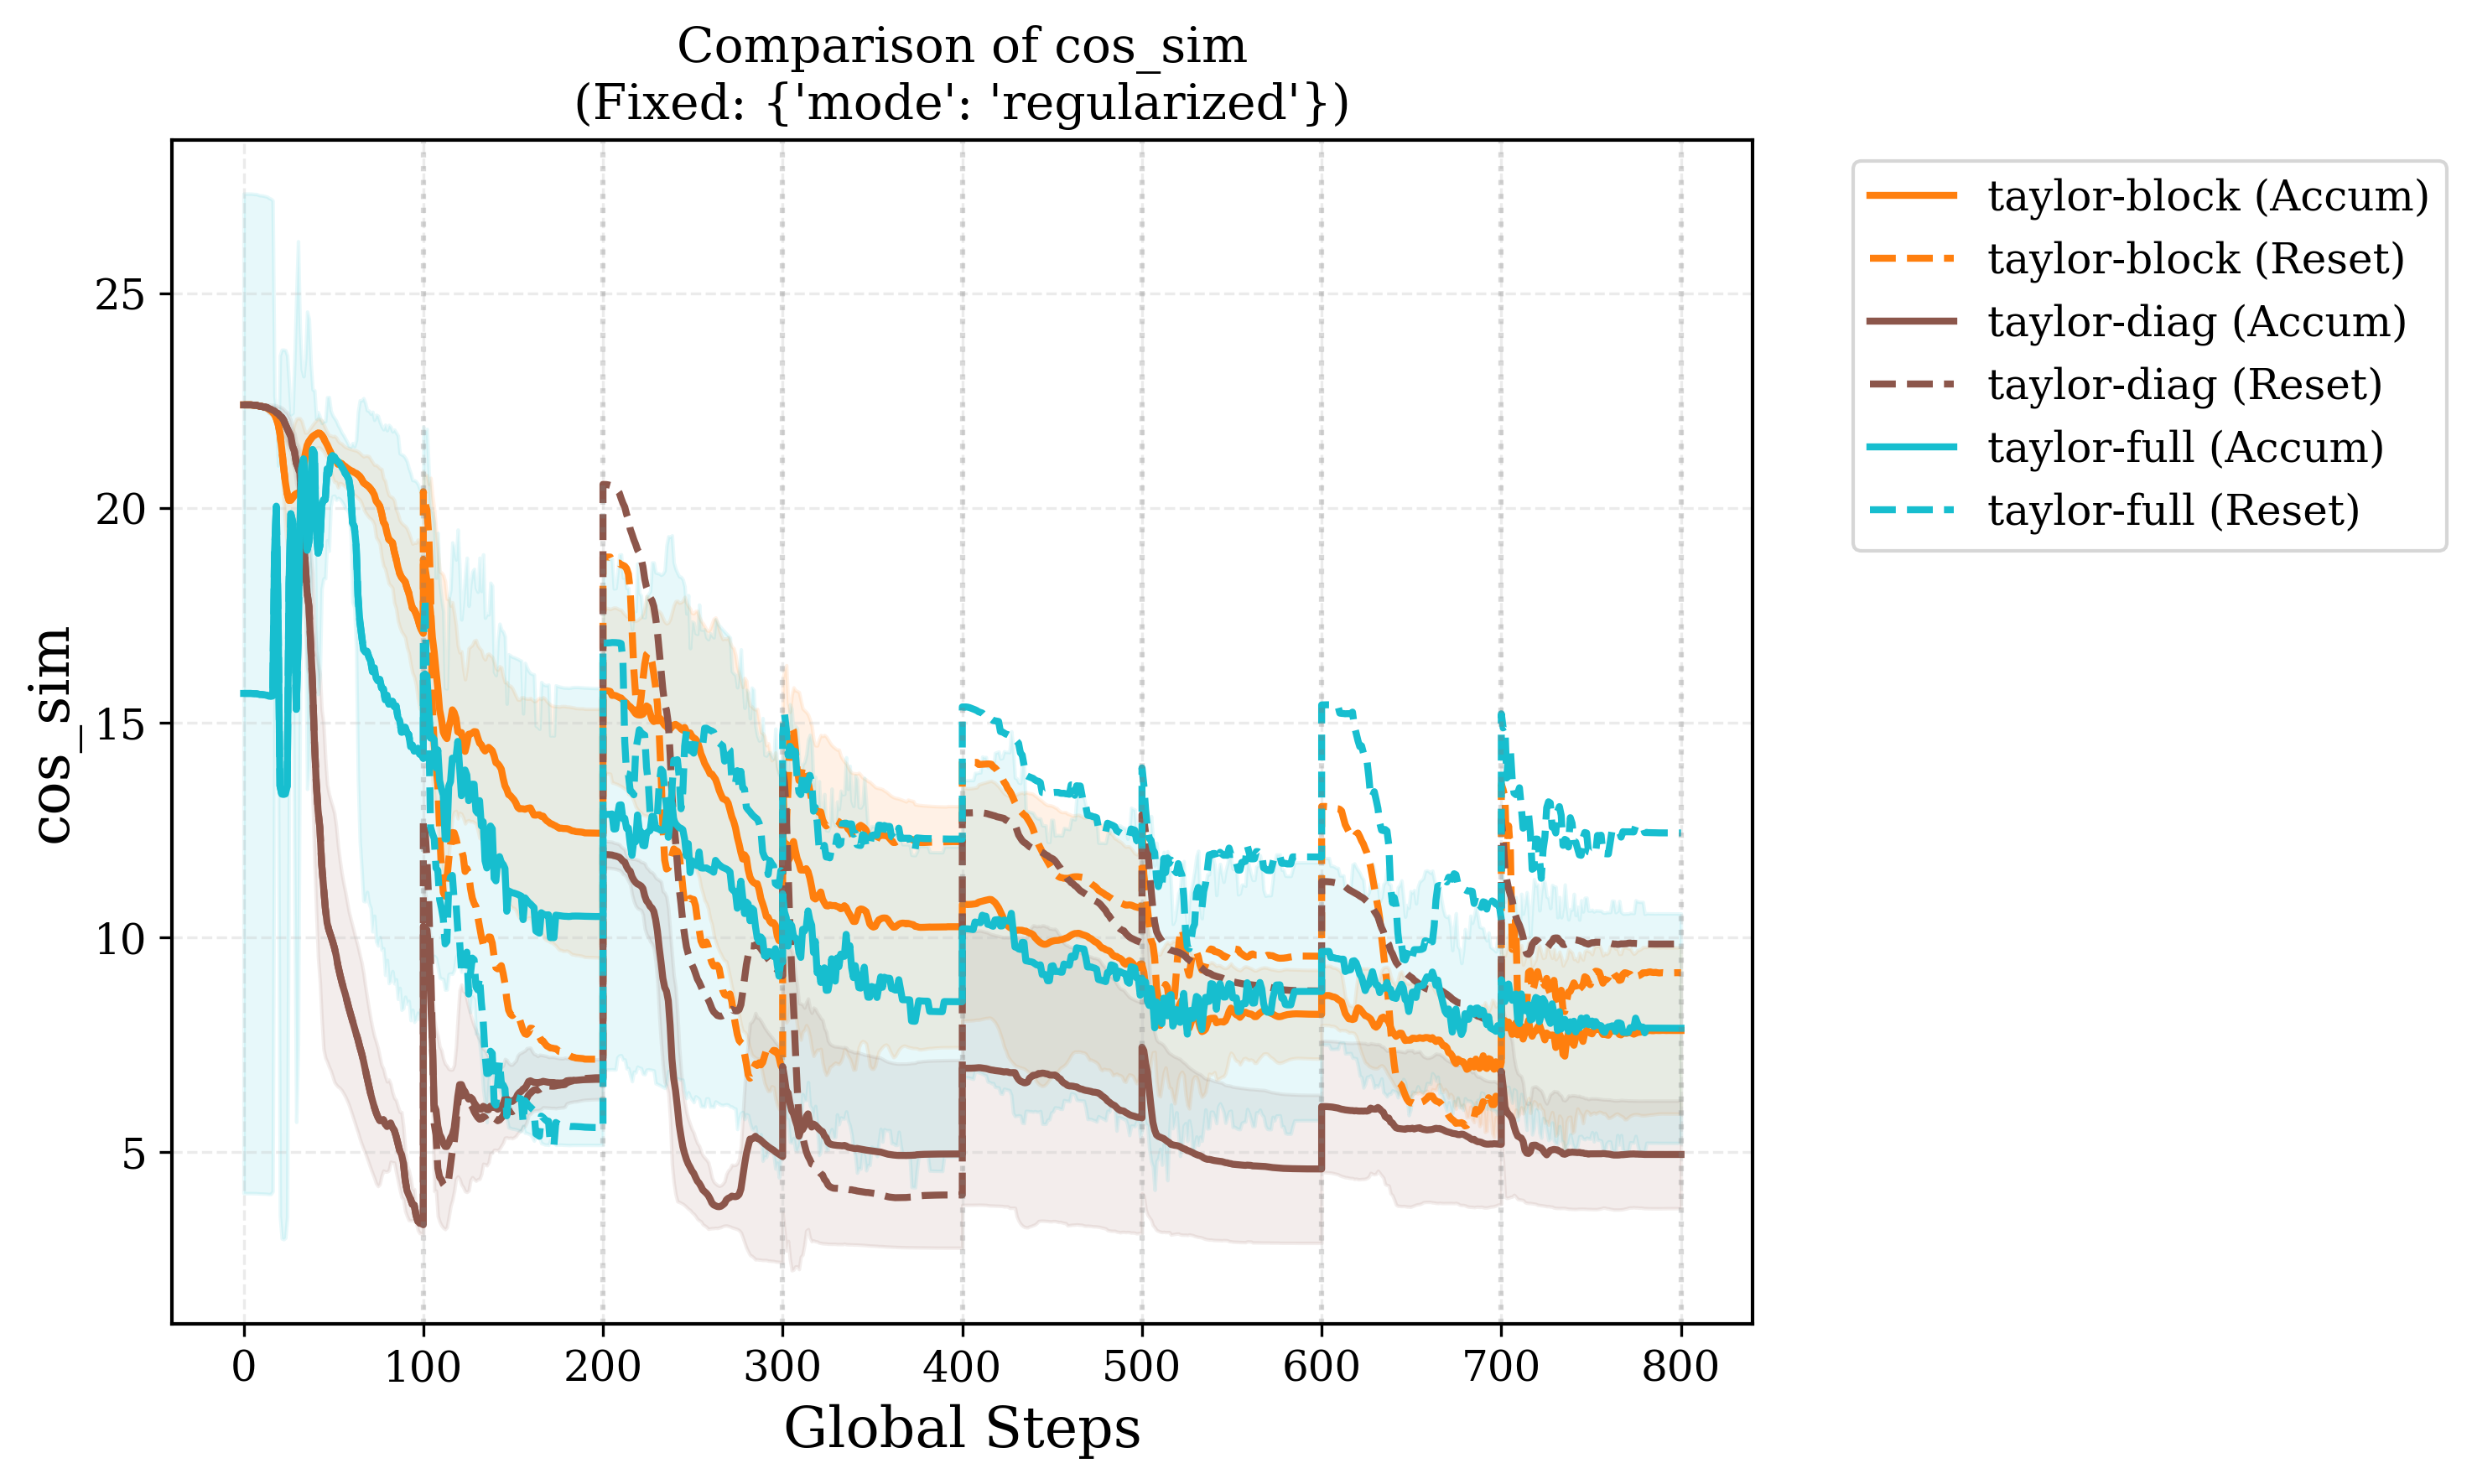

In [86]:
plot_metric_comparison(
    ROOT_DIR, 
    metric='cos_sim',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'regularized'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='hessian'
)
plot_metric_comparison(
    ROOT_DIR, 
    metric='cos_sim',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'regularized'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='fisher'
)


Indexing 55 experiments...
Comparing reg_type (Fixed: {'mode': 'regularized'}, Curv: hessian)...


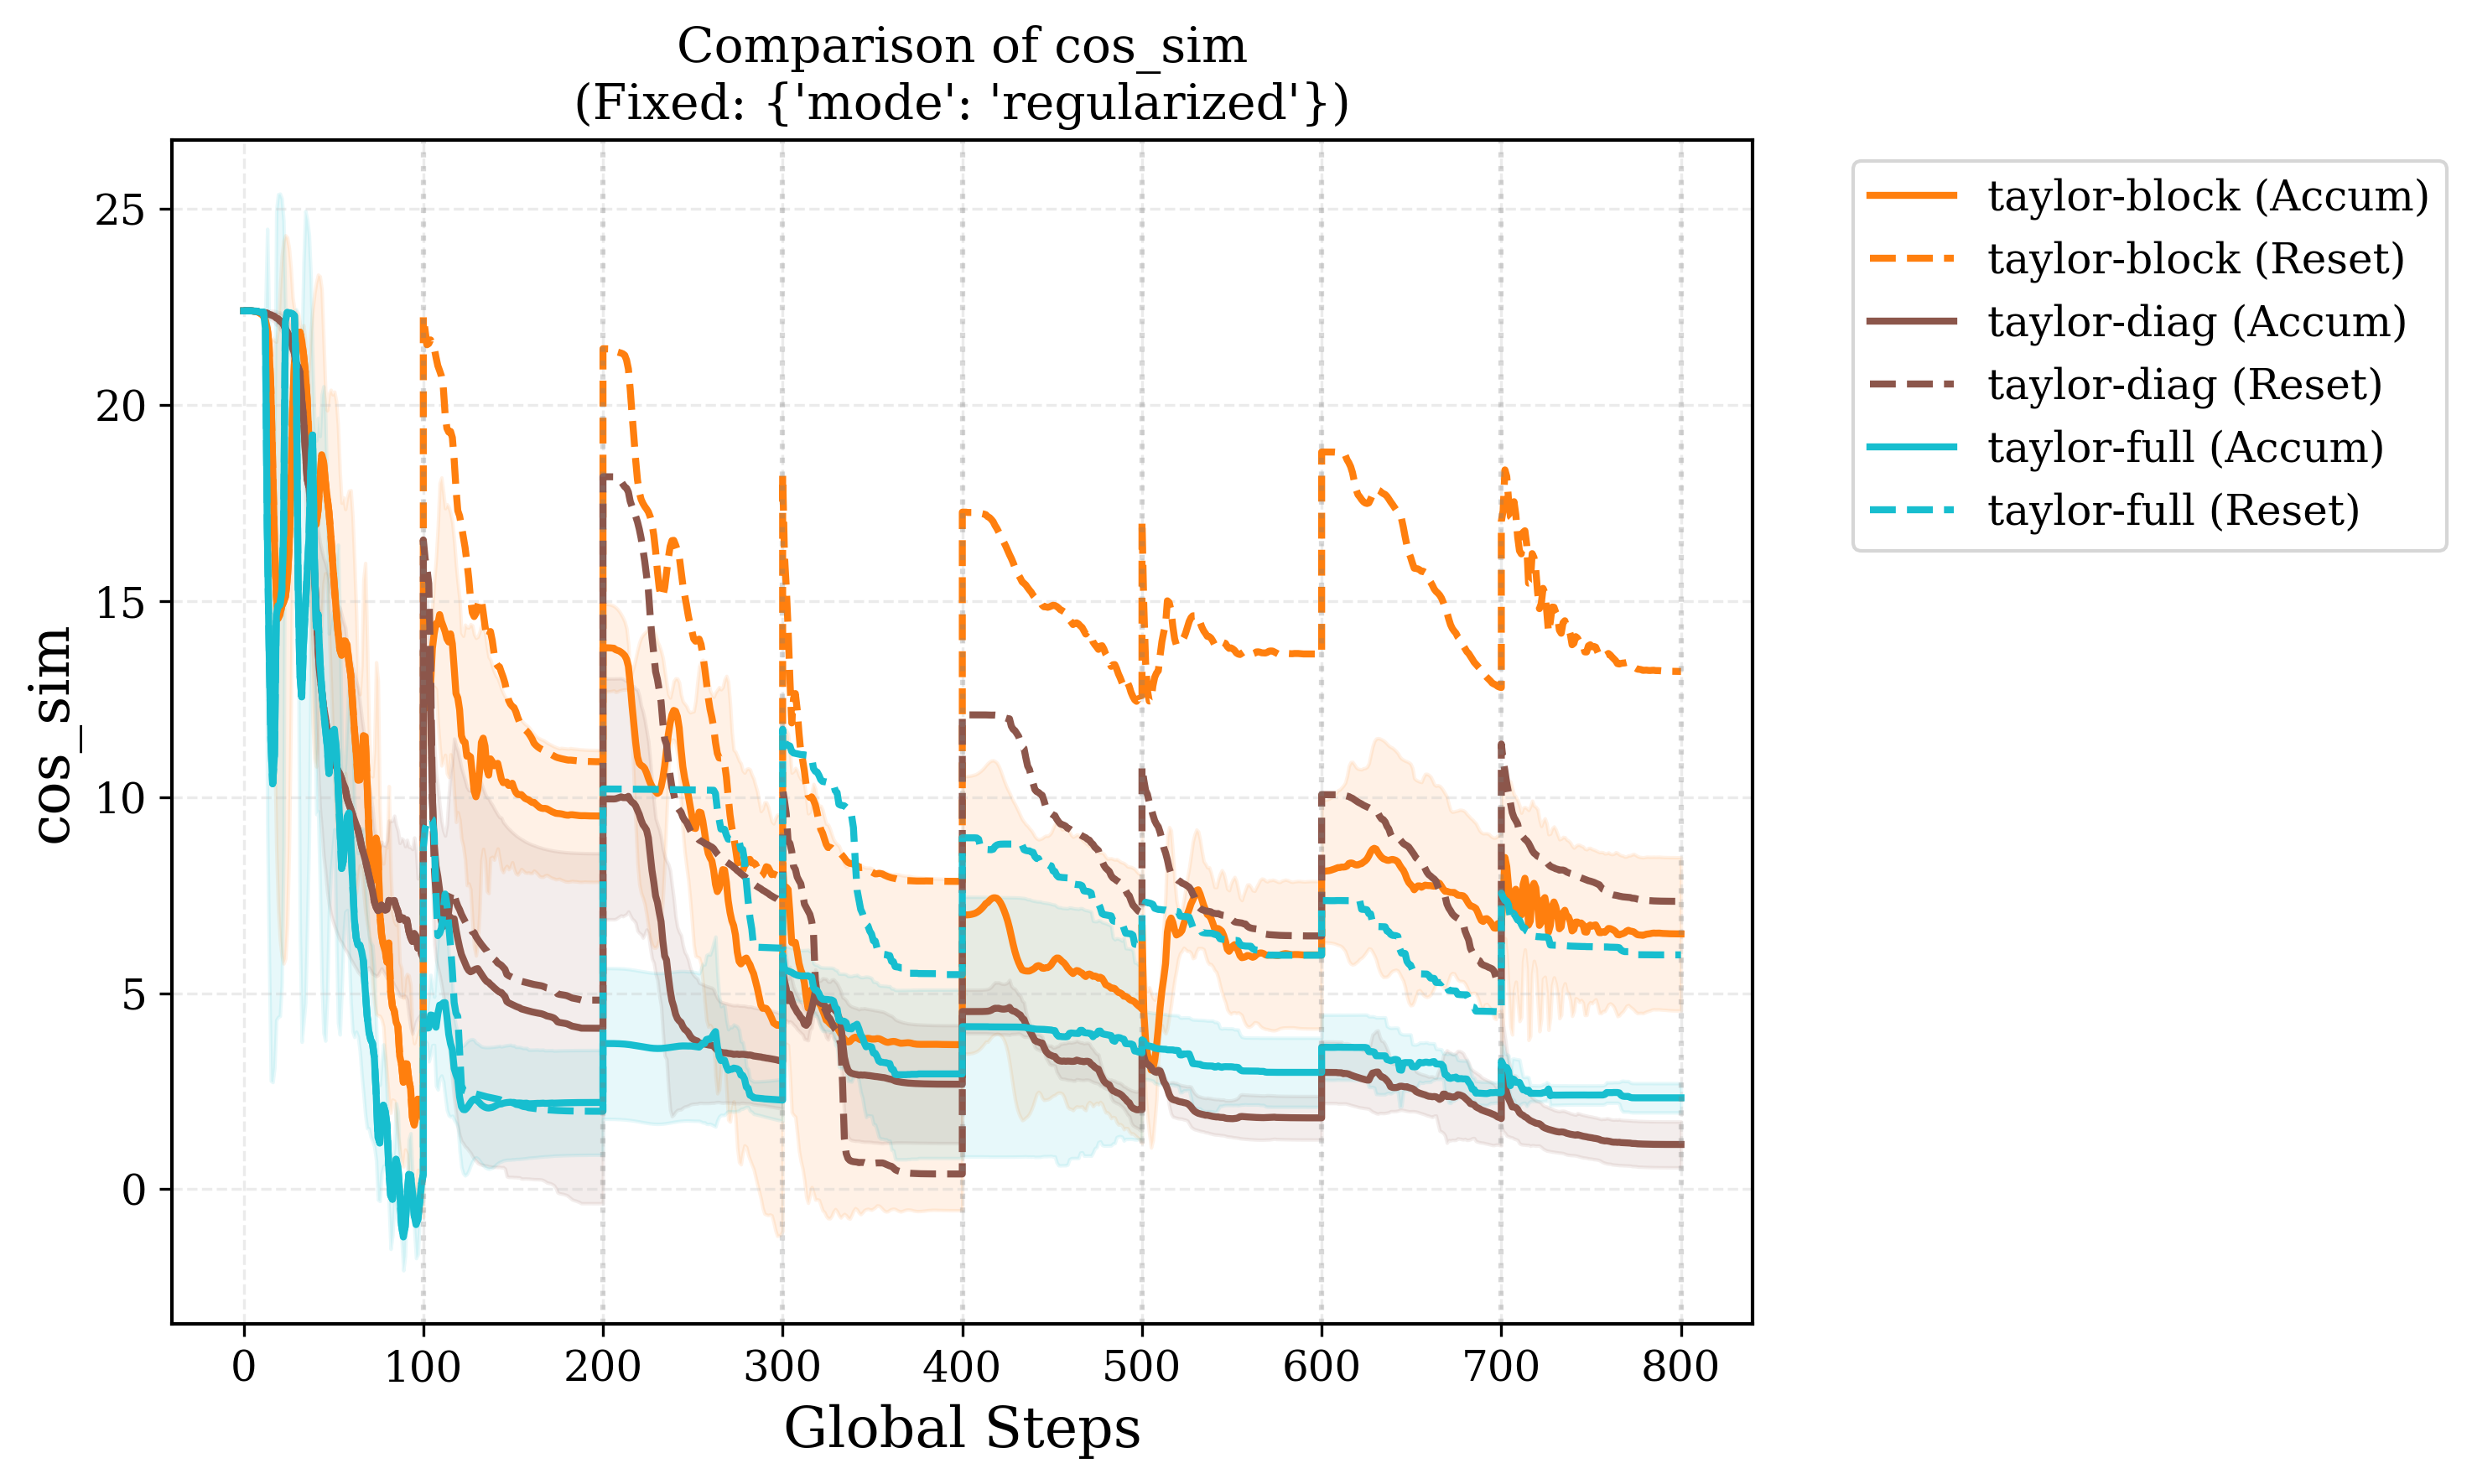

Indexing 55 experiments...
Comparing reg_type (Fixed: {'mode': 'sequential'}, Curv: hessian)...


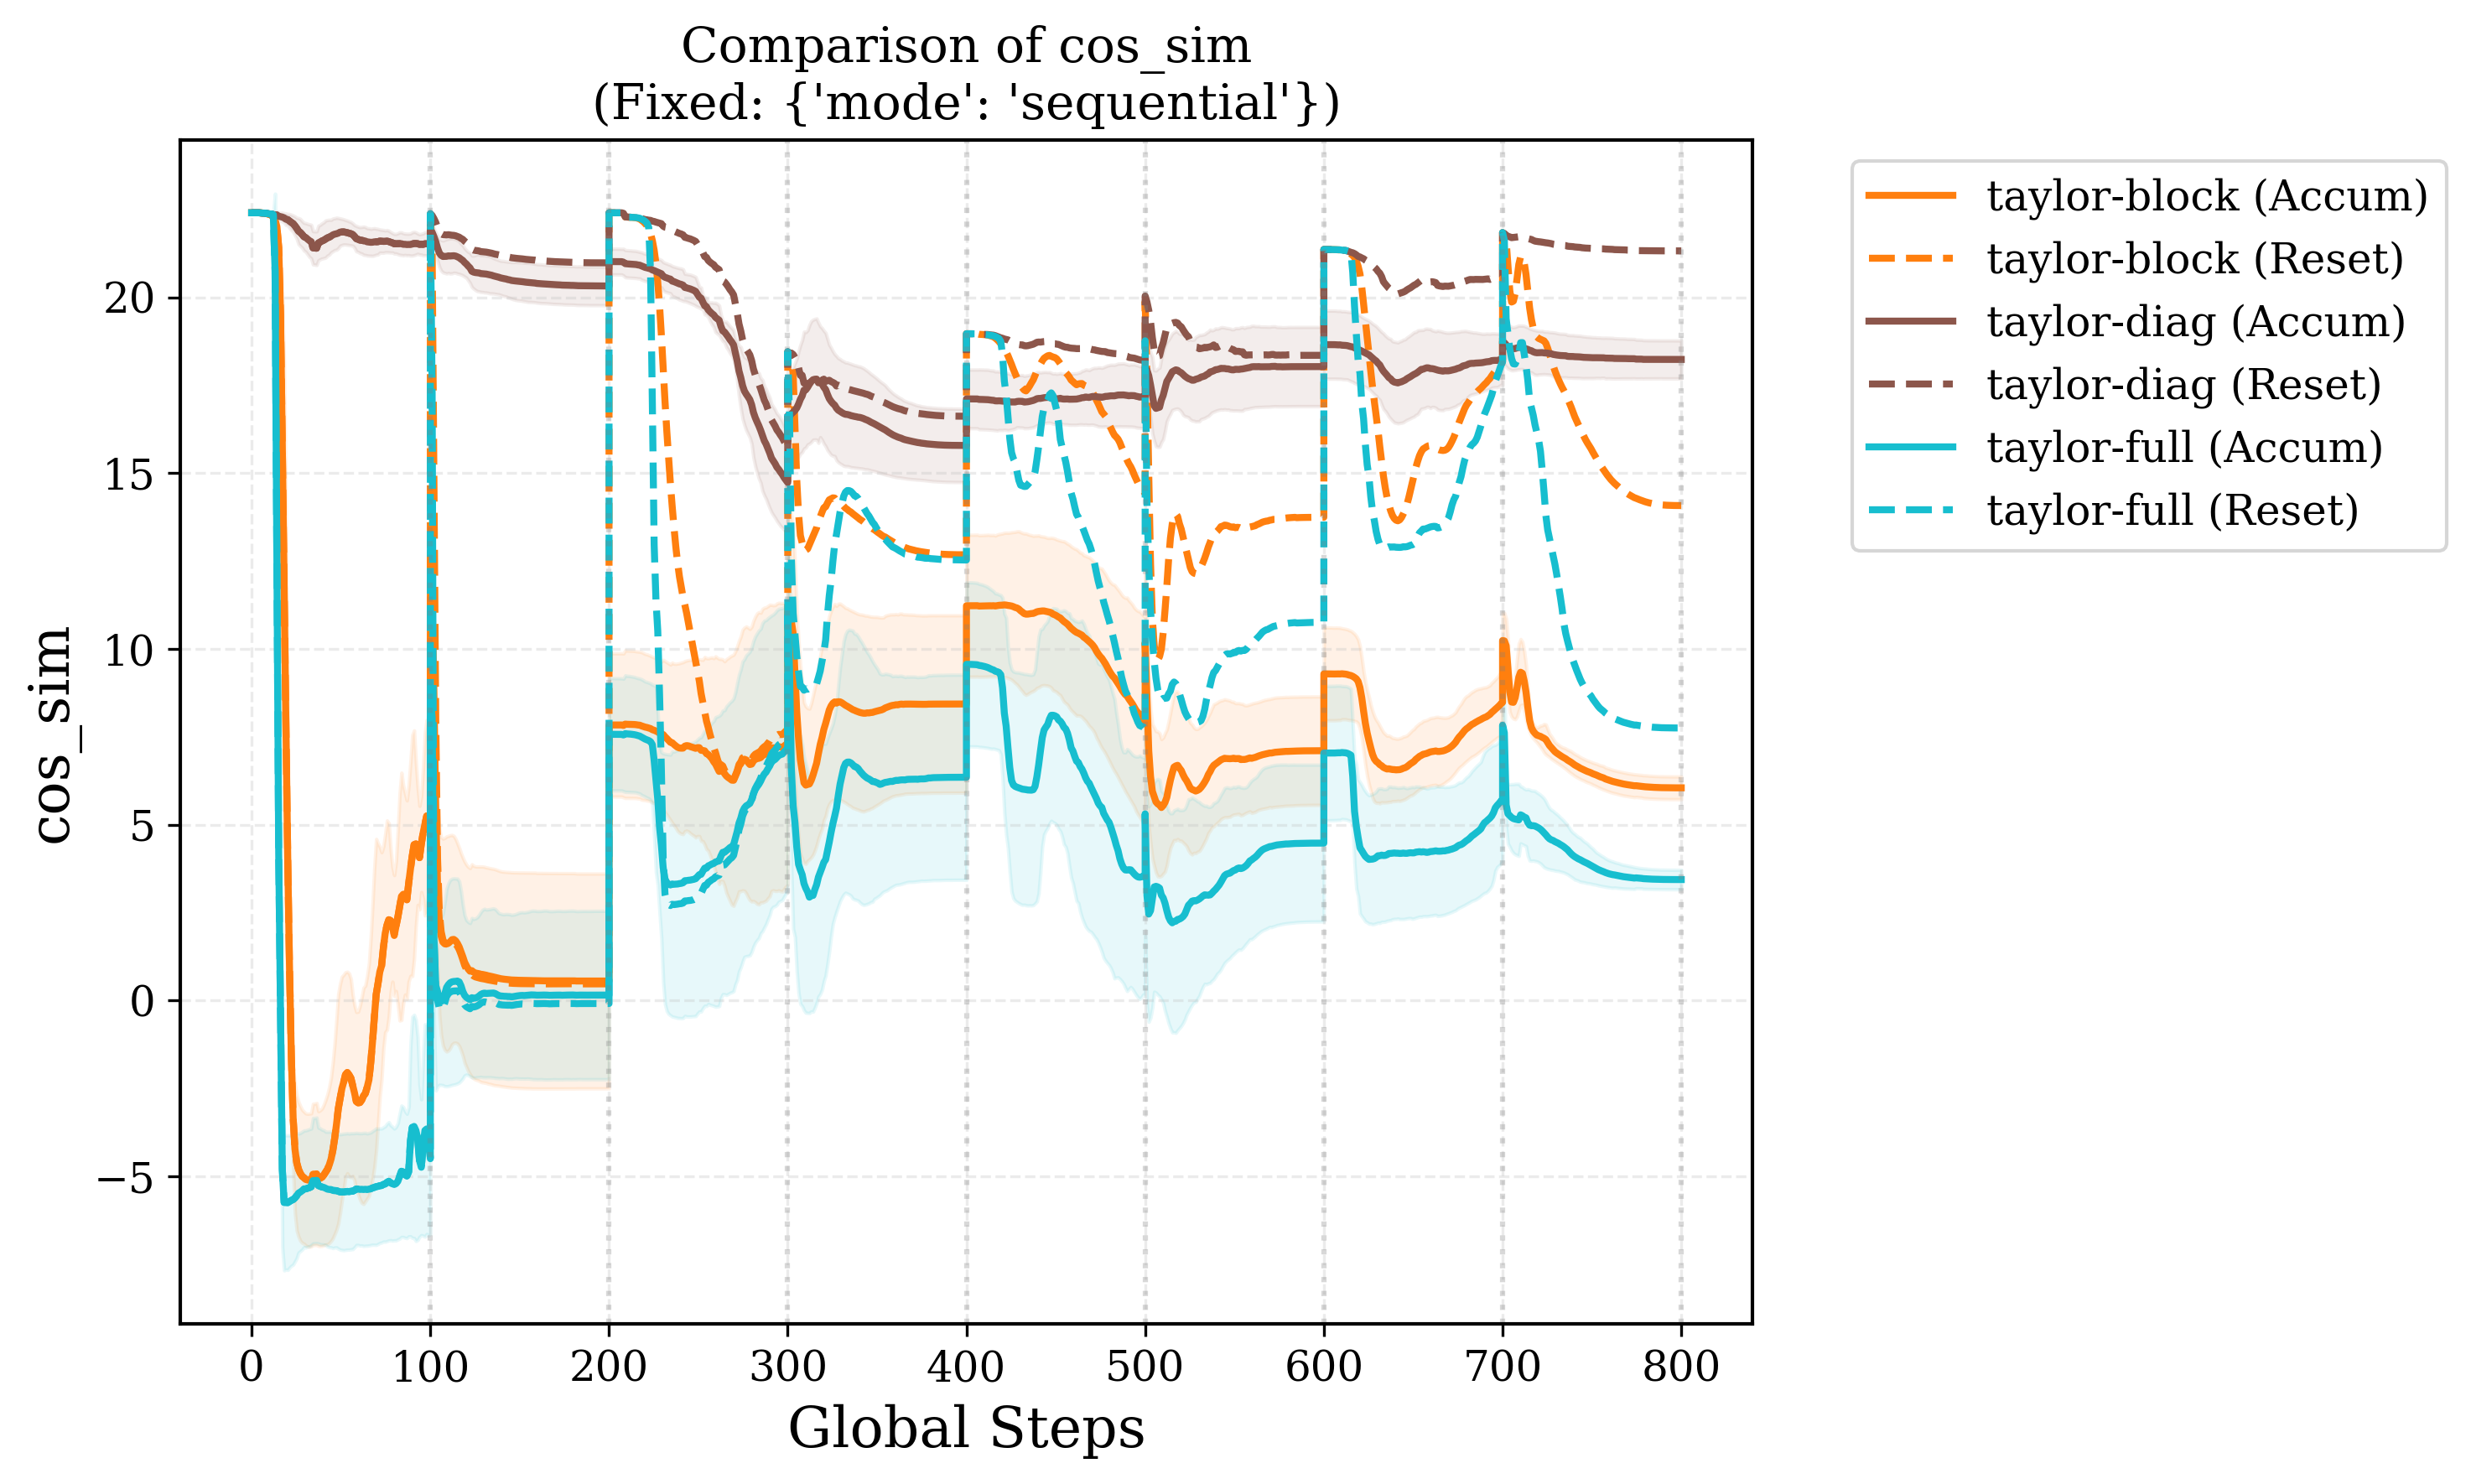

Indexing 55 experiments...
Comparing reg_type (Fixed: {'mode': 'replay'}, Curv: hessian)...


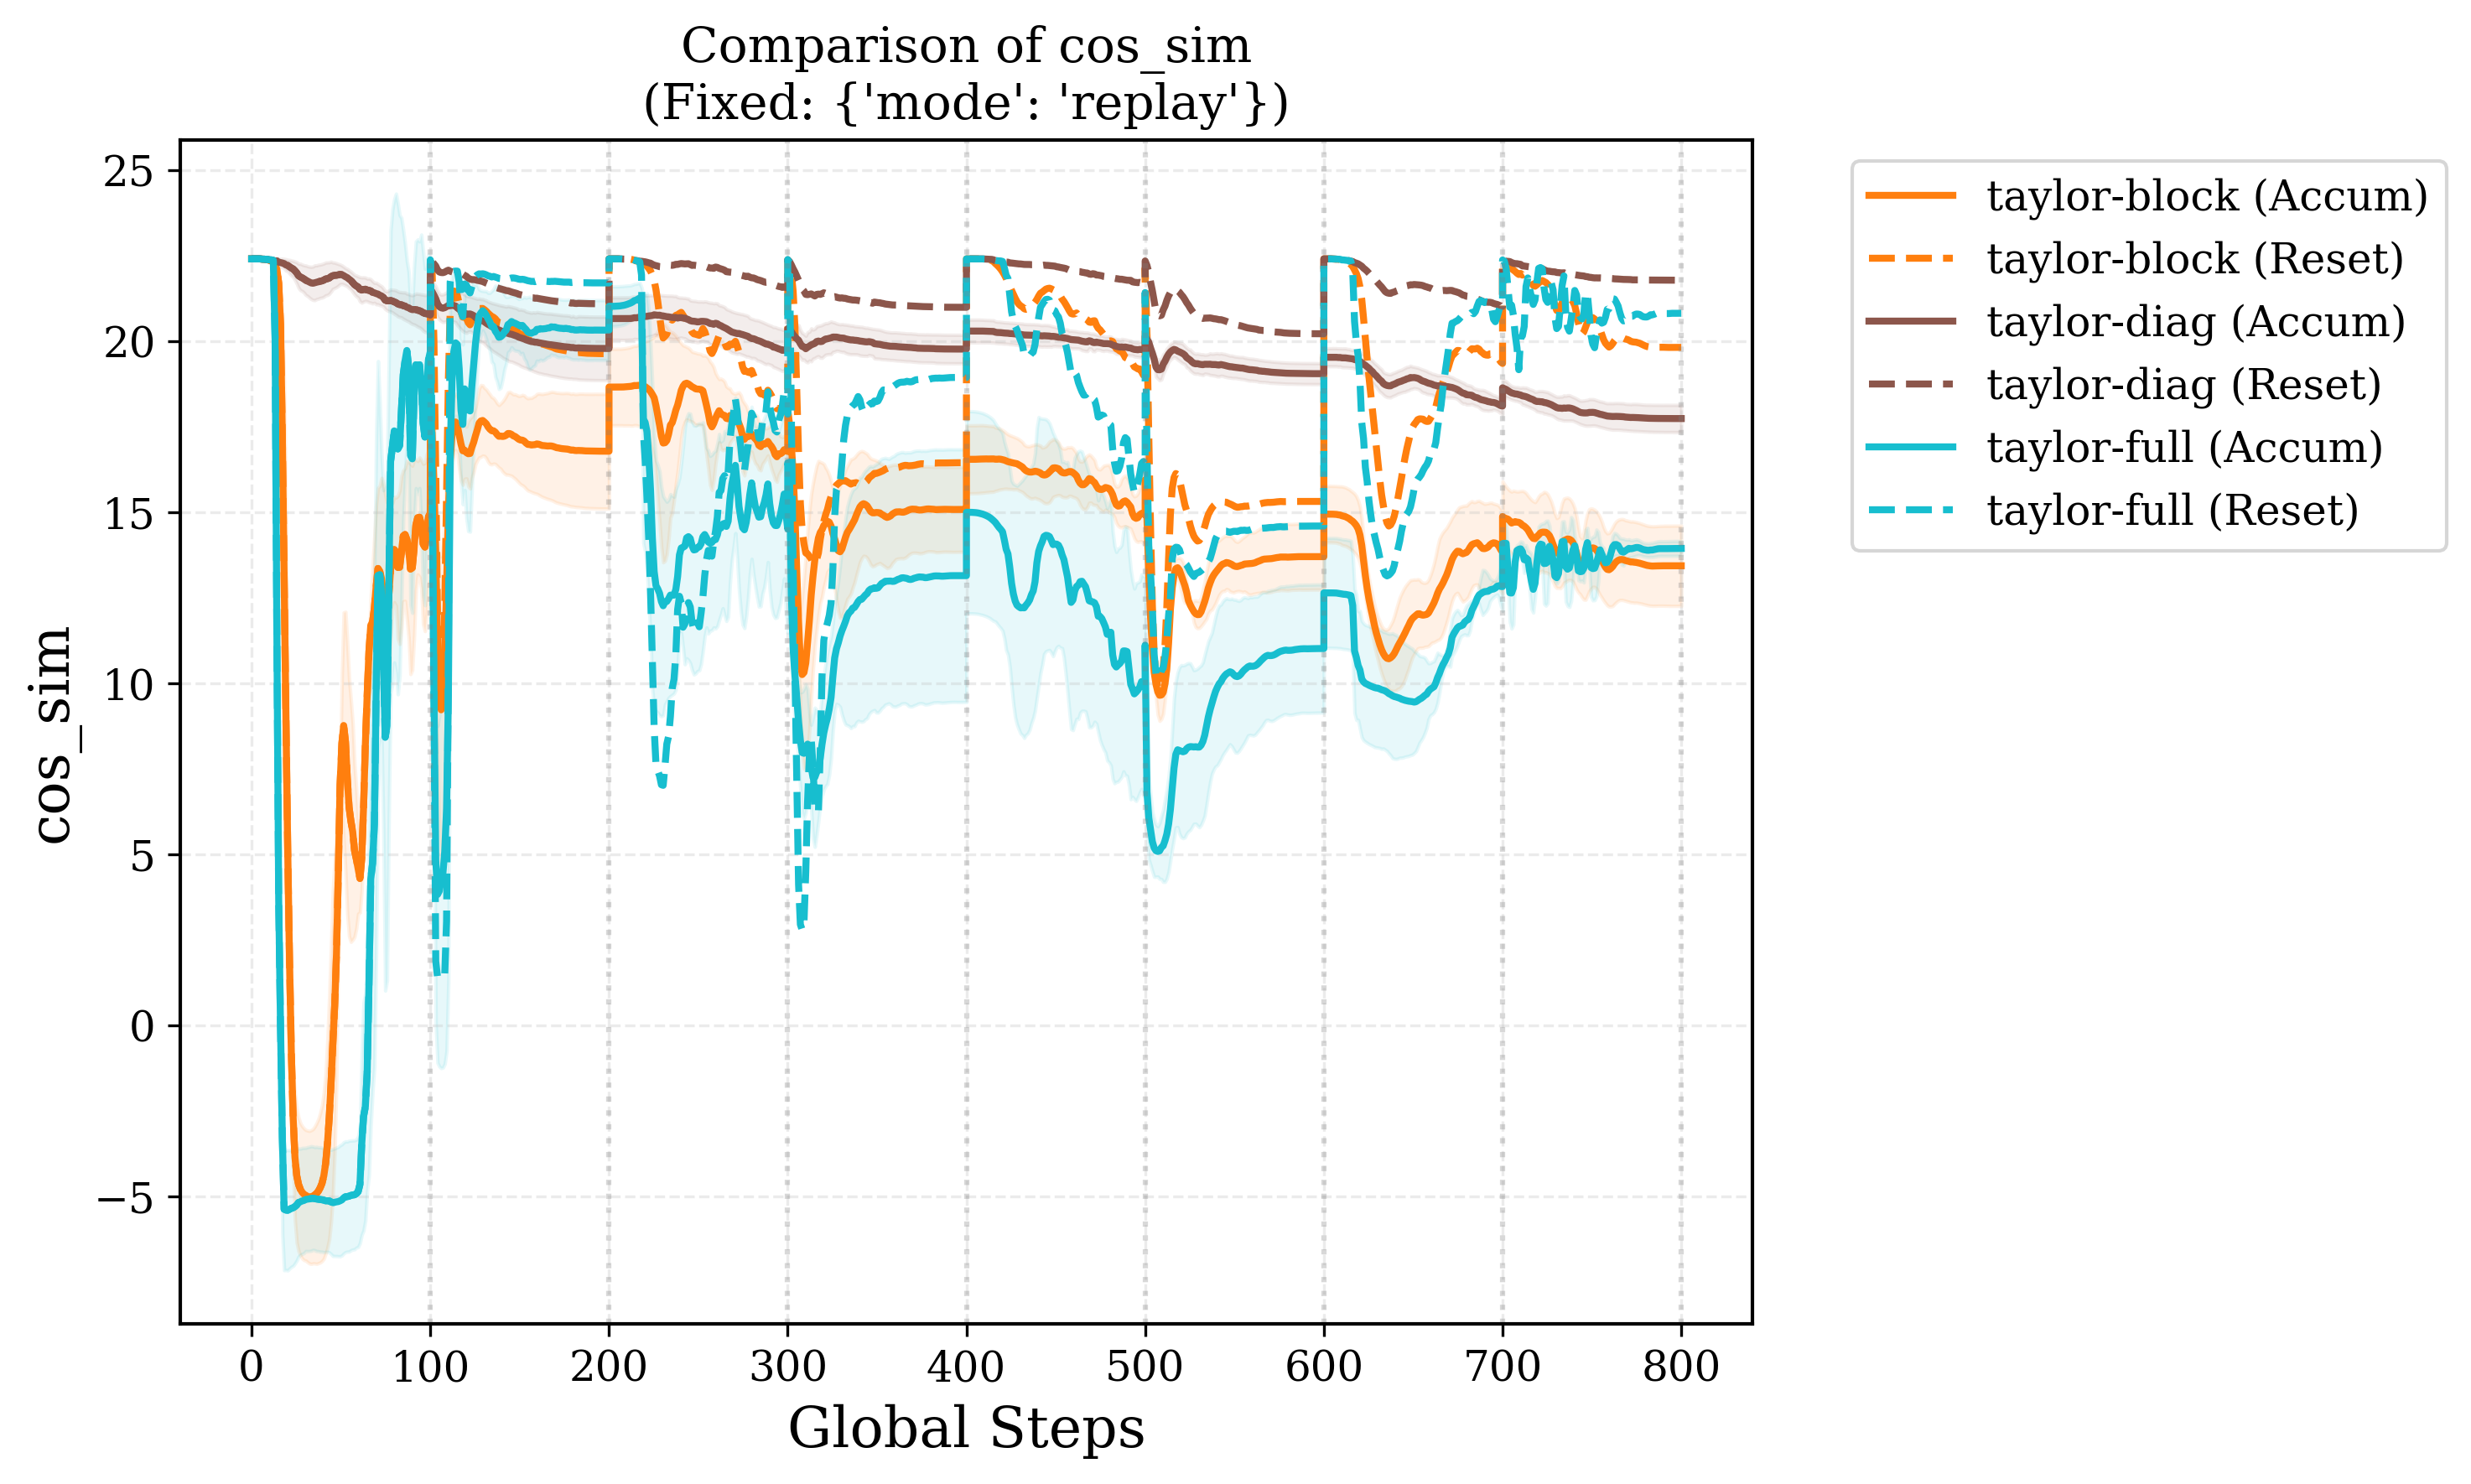

In [77]:
ROOT_DIR = './results/study_q2approx_v1'

plot_metric_comparison(
    ROOT_DIR, 
    metric='cos_sim',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'regularized'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='hessian'
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='cos_sim',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'sequential'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='hessian'
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='cos_sim',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'replay'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='hessian'
)